# Movie Recommender Project Report 
<br>
<font size=4> Team members: </font> <br><br>
<font size=3> James Jungsuk Lee [UNI] </font><br>
<font size=3> Ujjwal Peshin [UNI]</font><br>
<font size=3> Bowen Zhou [UNI]</font><br>
<font size=3> Zhongling Jiang [UNI]</font>

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 55kB/s 
     |████████████████████████████████| 204kB 43.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=76c86d68320c99fad3fdf89bbba3b5422458bdbb7ab0aadb454f2dafb9ffab5e
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [8]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678043 sha256=2df9c53ae305cb5bb08d588400b1b0d6041009be7416b429af3b3153925ee457
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [0]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import Window
from pyspark.sql.functions import col, expr
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from surprise import AlgoBase
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
import pandas as pd
import random

import itertools
RANDOM_SPLIT_SEED = 24
TRAIN_PROPORTION = 0.9
TEST_PROPORTION = 1 - TRAIN_PROPORTION

### Answer to 
As data scientists of a digital media company, state your objectives in building a
recommendation system. For example, what metrics do you care about, who is this system
built to serve (users or your boss?), and what business rules may you care to introduce?

As a data scientist, you want to create a solution that serves the users but as well as can satisify your coworkers such as your boss. Having key stakeholders bought into your idea is integral in adding value to the company. So here we list out a few metrics and ideas that we can focus on and also point out who they serve.

Users: <br/>
We want our users to feel engaged with our content. That means we want to push out recommendations that they can relate to and enjoy. Within the context of our project, we can measure accuracy of our model such as RMSE. However, there can be some other things we can measure as well that's a bit out of scope of this project such as serendipity of our recommendations and implicit feedbacks such as how long they listen or watch our recommendations even if they don't explicitly rate them.
    
Stakeholders: <br/>
Stakeholders want to make sure that the solutions that we recommend are indeed better than what they can do or have done in the past. They also want to understand how this system is affecting the product that they own. This means that measurements such as accuracy is also useful for stakeholders, but we can additionally focus on model methods that help them interpret the model's output. This means using simpler methods such as KNN or exploring Matrix Factorization methods to see if there can be any patterns in a reduced dimension space that can make sense to human rationality.

## Part I: Data Preparation

**Description: ** <br><br>

### Create a smaller development set

In [5]:
ratings = spark.read.csv('/gdrive/My Drive/Colab Notebooks/Data/ml-20m/ratings.csv', header = True, 
                         inferSchema=True).cache()
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
pd.DataFrame(ratings.take(5), columns=ratings.columns)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
random.seed(100)

In [8]:
def subsample(movies, n, p):
    """
    The function subsample the list of movies that each user rates, based on following rule:
    (i) If user has rated fewer than n movies, we keep all ratings
    (ii) If user has rated a lot of movies, we keep only p percent of them via random selection
    (iii) If number of movies * p percent is less than n, we randomly sample n movies and 
         keep these ratings
    """
    if len(movies) <= n:
        return movies
    elif int(p * len(movies)) <= n:
        return random.sample(movies, n)
    else:
        return random.sample(movies, int(p * len(movies)))
N = 5
P = 0.01   
# collect all movies each user has rated
ratings_rdd = ratings.select(['userId', 'movieId']).rdd.map(list)
users_rated_movies = ratings_rdd.groupByKey().mapValues(list)

# call subsample on rated movies
subsampled_users_rated_movies= users_rated_movies.mapValues(lambda m: subsample(m, N, P))

# Now convert these ratings back to dataframe
subsampled_ratings = subsampled_users_rated_movies.flatMapValues(lambda x: x)
subsampled_ratings = spark.createDataFrame(subsampled_ratings, ['userId', 'movieId'])

# check size of the subsampled dataset
subsample_rowcounts = subsampled_ratings.count()
subsample_percentage = subsample_rowcounts * 1.0 / ratings.count() * 100
print ('The subsampled dataset is {0}% size of the original dataset, has {1} rows'.\
       format(subsample_percentage, subsample_rowcounts))

The subsampled dataset is 3.586952831570265% size of the original dataset, has 717400 rows


In [9]:
# Join them back to original dataset to get ratings and time stamps, using userId and movieId as key
subsampled_ratings = subsampled_ratings.join(ratings, ['userId','movieid'], 'inner')
subsampled_ratings.persist()
pd.DataFrame(subsampled_ratings.take(5), columns=subsampled_ratings.columns)

,userId,movieId,rating,timestamp
0,25,372,4.0,1277961712
1,33,3596,1.0,966285315
2,71,112556,5.0,1417454105
3,258,50872,2.5,1220756369
4,273,5507,2.0,1044297869


### Divide into training, validation and test set <br>

**Description**: <br><br>


**Output**: 'train' - training set,  'val' - validation set, 'test' - test set

In [10]:
subsampled_ratings = subsampled_ratings.withColumn("timestamp", ratings["timestamp"].cast(T.TimestampType()))
subsampled_ratings.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [0]:
limit = 3
# test size
test_size = 0.05
def udf_user_limit(user_counts):
    if user_counts < limit:
        return -1
    else:
        if (user_counts * (1-test_size)) <= limit:
            return limit
        else:
            return int(np.around(user_counts * (1-test_size)))
user_limit = F.udf(udf_user_limit, T.IntegerType())

In [0]:
# train-test function
def train_test_split(data, col_to_split_on= 'userId', timestamp_col = 'timestamp'):
    # original columns
    orig_cols = data.columns
    # define count col
    count_col = 'count(' + col_to_split_on + ')'
    # do user ratings count
    counts_for_col = data.groupby(col_to_split_on).agg(F.count(col_to_split_on))
    # generate limits on each user based on rules
    limits = counts_for_col.withColumn('train_limit', user_limit(F.col(count_col)))
    # remove users having less than limit no of ratings
    limits_filtered = limits.filter(limits.train_limit > 0)
    # generate row numbers based on temporality
    data_row_num = data.withColumn("row_num", F.row_number().over(Window.partitionBy(col_to_split_on).orderBy(timestamp_col)))
    # join ratings and user counts dfs together
    data_row_num = data_row_num.alias('a')
    limits_filtered = limits_filtered.alias('b')
    merged_data = data_row_num.join(limits_filtered,F.col('b.' + col_to_split_on) == F.col('a.' + col_to_split_on)).select([F.col('a.'+xx) for xx in data_row_num.columns] + [F.col('b.' + count_col),F.col('b.train_limit')])
    # generate selection column based on number limit
    final_train_test = merged_data.withColumn('selection', F.col('row_num') <= F.col('train_limit'))
    # find train and test 
    train = final_train_test.filter(final_train_test.selection == True).select(orig_cols)
    test = final_train_test.filter(final_train_test.selection == False).select(orig_cols)
    return train, test

In [0]:
# to check if test has more entities in any column
def compatibility_test(train, test, cols_to_test = ['userId', 'movieId']):
    cols_greater = []
    for i in cols_to_test:
        train_unique = train.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
        test_unique = test.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
        size = len(list(set(test_unique) - set(train_unique)))
        print("Test has %d more %s" %(size, i))
        cols_greater.append(i)
    return cols_greater

In [14]:
traincv, test = train_test_split(subsampled_ratings, col_to_split_on= 'movieId', timestamp_col='timestamp')
print((traincv.count(), len(traincv.columns)))
print((test.count(), len(test.columns)))
cols_greater = compatibility_test(traincv, test, cols_to_test=['userId', 'movieId'])

(677061, 4)
(34966, 4)
Test has 1116 more userId
Test has 0 more movieId


In [15]:
for i in cols_greater:
    traincv_unique = traincv.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    test_unique = test.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    unique_to_test = list(set(test_unique) - set(traincv_unique))
    test = test[~test[i].isin(unique_to_test)]
# After removing users/ movies not included in training set
print((traincv.count(), len(traincv.columns)))
print((test.count(), len(test.columns)))
cols_greater = compatibility_test(traincv, test, cols_to_test=['userId', 'movieId'])
test.persist()

(677061, 4)
(29481, 4)
Test has 0 more userId
Test has 0 more movieId


DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: timestamp]

Repeat the same logic on train / validation set split

In [16]:
train, val = train_test_split(traincv, col_to_split_on= 'movieId', timestamp_col='timestamp')
print((train.count(), len(train.columns)))
print((val.count(), len(val.columns)))
cols_greater = compatibility_test(train, val, cols_to_test=['userId', 'movieId'])

(644002, 4)
(33059, 4)
Test has 1854 more userId
Test has 0 more movieId


In [17]:
for i in cols_greater:
    train_unique = train.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    val_unique = val.select([i]).distinct().rdd.map(lambda x: x[0]).collect()
    unique_to_val = list(set(val_unique) - set(train_unique))
    val = val[~val[i].isin(unique_to_val)]
print((train.count(), len(train.columns)))
print((val.count(), len(val.columns)))
cols_greater = compatibility_test(train, val, cols_to_test=['userId', 'movieId'])
train.persist()
val.persist()

(644002, 4)
(29317, 4)
Test has 0 more userId
Test has 0 more movieId


DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: timestamp]

### Evaluation Metrics

We explored mainly two type of evaluation metrics on our recommender system -- regression metrics and ranking metrics.
The problem setting can be described as the following: 

Assume U is a set of M users, $U=\{u_0,u_1,...,u_{M−1}\}$. 

Each user $u_i$ having a set of N ground truth relevant movies $Di=\{d_0,d_1,...,d_{N−1}\}$ and a list of Q recommended movies, in order of decreasing relevance $Ri=\{r_0,r_1,...,r_{Q−1}\}$

Our goal is to evaluate how relevant our recommended movies are for each user. The relevance of the sets and the effectiveness of the algorithms can be measured using the metrics listed below.

Before diving into definition of metrics, we define a indicator function which, provided a recommended document and a set of ground truth relevant documents, returns a 0/1 score to indicate relevance.

$rel_D(r)$ = \begin{cases}
    1,& \text{if } r\in D\\
    0,              & \text{otherwise}
\end{cases}


#### I. Regression Metric

* Root Mean Square Error (RMSE): $\frac{\sqrt{\sum_{i=0}^{N - 1}e_{i}^2}}{N}$
* Mean Absolute Error (MAE): $\frac{\sum_{i=0}^{N - 1}|e_{i}|}{N}$
* R-squared: $1 - \frac{\sum_{i=0}^{N - 1} (e_i)^2 }{\sum_{i=0}^{N - 1} (y_i - \bar{y}_i)^2}$
* Explained Variance: $1 - \frac{Var(y - \hat{y})}{Var(y)} $

In [0]:
def regression_metric(ratings, predicted_ratings):
    """
        Calculate regression metrics
        - root mean square error
        - mean absoluate error
        - r squared
        - explained variance
        by joining original and predicted rating dataset into 
        ((userId, movieId), (original_rating, predicted_rating)).
        :ratings: original rating dataset. Format:   userId | movieId | rating
        :predicted_ratings: predicted rating dataset
    """
    ratings_tuple = ratings.rdd.map(lambda r: ((r.userId, r.movieId), r.rating))
    predicted_ratings_tuple = predicted_ratings.rdd.map(lambda r: ((r.userId, r.movieId), r.rating))
    score_and_labels = predicted_ratings_tuple.join(ratings_tuple).map(lambda tup: tup[1])
    metrics = RegressionMetrics(score_and_labels)
    print("RMSE = %s" % metrics.rootMeanSquaredError)
    print("MAE = %s" % metrics.meanAbsoluteError)
    print("R-squared = %s" % metrics.r2)
    print("Explained Variance = %s" % metrics.explainedVariance)
    return metrics.rootMeanSquaredError, metrics.meanAbsoluteError, metrics.r2, metrics.explainedVariance

#### II. Ranking Metric

* Precision @ k: measures on average what proportion of first k recommended movies to users are contained in true set of relevant movies to each user, i.e.<br>

<font size=2.5>$p(k) = \frac{1}{M}\sum_{i=0}^{M-1}\frac{1}{k}\sum_{j=0}^{min(|D|, k)-1}rel_{D_i}(R_i(j))$</font>

* Mean Average Precision @ k: measures similar quantity as Precision @ k except imposing penalty regarding order of recommendation, i.e. <br>

<font size=2.5>$p(k) = \frac{1}{M}\sum_{i=0}^{M-1}\frac{1}{k}\sum_{j=0}^{min(|D|, k)-1}\frac{rel_{D_i}(R_i(j))}{j + 1}$</font>

* Normalized Discounted Continuous Gain (NDCG): measures how many of the first k recommended moveis are in the set of true relevant documents averaged across all users, while taking into account the order of the recommendations (movies are assumed to be in order of decreasing relevance).

<font size=2.5>$NDCG(k) = \frac{1}{M}\sum_{i=0}^{M-1} \frac{1}{IDCG(D_i, k)}\sum_{j=0}^{n-1}\frac{rel_{D_i}(R_i(j))}{ln(j + 1)} $<font> <br>
where $IDCG(k) = \sum_{j=0}^{min(|D|, k)-1}\frac{rel_{D_i}(R_i(j))}{ln(j + 1)}$ represents best possible attained by the most ideal ranking.
    
**Procedure**:

(i) Filter out movies with rating score < r, because we are only interested in evaluating relevant movies, or 'good' recommendations. 

(ii) Sort ground truths and predictions by ratings (predicted ratings) and retrieve top k movies as reccommended items for a user. If in test set, a user rates fewer than k movies, then only retrieve all his rated movies.


(iii) Calculate specific ranking metric on test set and predicted set.

In [0]:
# Ranking metrics
# https://vinta.ws/code/spark-ml-cookbook-pyspark.html
def ranking_metric(ratings, predicted_ratings, r=3, k=5):
    """
        Calculate ranking metrics
        - mean average precision
        - precision at k
        - normalized discounted continuous gain at k
        by collecting recommended items and then comparing them to relevant groud truth items, 
        which takes form of
        ((userId, movieId), ([[predicted_item1, predicted_item2, ...], [item1, item2, ...]))
        :ratings: original rating dataset. Format:   userId | movieId | rating
        :predicted ratings: predicted rating dataset, same format
        :r: threshold for rating that defines a 'relevant' movie
        :k: top k positions used for comparison
    """
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .groupBy('userId') \
        .agg(expr('collect_list(movieId) as itemsId'))
    
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserActualItemsDF = ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .groupBy('userId') \
        .agg(expr('collect_list(movieId) as itemsId')) 
    
    perUserItemsRDD = perUserPredictedItemsDF.join(perUserActualItemsDF, 'userId') \
        .rdd \
        .map(lambda row: (row[1], row[2]))
    rankingMetrics = RankingMetrics(perUserItemsRDD)

    print("mean Average Precision = %s" %rankingMetrics.meanAveragePrecision)
    print("Precision at k = %s" %rankingMetrics.precisionAt(k))
    print("NDCG at k = %s" %rankingMetrics.ndcgAt(k))  
    
    return rankingMetrics.meanAveragePrecision, rankingMetrics.precisionAt(k), rankingMetrics.ndcgAt(k)

#### III. Coverage

In [0]:
def user_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings_baseline \
        .where('rating >= {0}'.format(r)) \
        .select(col('userId').alias('p_userId'), col('movieId').alias('p_movieId'), \
                F.col('rating').alias('p_ratings'), F.rank().over(windowSpec).alias('rank'))  
    # join with test set ratings and rename columns
    joined = perUserPredictedItemsDF \
        .join(val, (perUserPredictedItemsDF.p_userId ==val.userId) & (perUserPredictedItemsDF.p_movieId == val.movieId))     
    # the number of users have above threshold, 'successful' recommendations
    covered_users = joined.where('rating >= {0}'.format(r)) \
        .groupBy('p_userId') \
        .agg(F.countDistinct('p_movieId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('p_userId'))    
    covered_users = covered_users.collect()[0][0]
    # the numeber of user have above threshold groudtruths 
    actual = val.where('rating >= {0}'.format(r)) \
        .groupBy('userId') \
        .agg(F.countDistinct('movieId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('userId'))
    total_users = actual.collect()[0][0]
    
    user_coverage = covered_users * 1.0 / total_users
    return user_coverage
            
def item_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('movieId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings_baseline \
        .where('rating >= {0}'.format(r)) \
        .select(col('userId').alias('p_userId'), col('movieId').alias('p_movieId'), \
                F.col('rating').alias('p_ratings'), F.rank().over(windowSpec).alias('rank'))  
    # join with test set ratings and rename columns
    joined = perUserPredictedItemsDF \
        .join(val, (perUserPredictedItemsDF.p_userId ==val.userId) & (perUserPredictedItemsDF.p_movieId == val.movieId))     
    # the number of users have above threshold, 'successful' recommendations
    covered_users = joined.where('rating >= {0}'.format(r)) \
        .groupBy('p_movieId') \
        .agg(F.countDistinct('p_userId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('p_movieId'))    
    covered_users = covered_users.collect()[0][0]
    # the numeber of user have above threshold groudtruths 
    actual = val.where('rating >= {0}'.format(r)) \
        .groupBy('movieId') \
        .agg(F.countDistinct('userId').alias('count')) \
        .where('count >= {0}'.format(k)) \
        .agg(F.countDistinct('movieId'))
    total_users = actual.collect()[0][0]
    
    user_coverage = covered_users * 1.0 / total_users
    return user_coverage


def catelog_coverage_metric(ratings, predicted_ratings, r=3, k=5):
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    perUserPredictedItemsDF = predicted_ratings \
        .where('rating >= {0}'.format(r)) \
        .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
        .where('rank <= {0}'.format(k)) \
        .agg(F.countDistinct('movieId'))
    num_rec_movies = perUserPredictedItemsDF.collect()[0][0]
    
    perUserActualItemsDF = ratings \
        .select('movieId') \
        .agg(F.countDistinct('movieId'))
    num_total_movies = perUserActualItemsDF.collect()[0][0]
    return num_rec_movies * 1.0 / num_total_movies

### Baseline Model <br>

**Description:**

In [0]:
class BaselineModel:

    def __init__(self, user_column, item_column,ratings_column):
        self.user_col = user_column
        self.item_col = item_column
        self.ratings_col = ratings_column

    def __find_avg_of_col(self, data, column):
        return data.select(F.mean(F.col(column))).collect()[0][0]

    def __subtract_from_col(self, data, column, value):
        return data.withColumn('normalized_' + column, F.col(column)-value)

    def train(self, training_data):
        user_col = self.user_col
        item_col = self.item_col
        ratings_col = self.ratings_col
        user_bias = {}
        item_bias = {}

        # find average and calculate bias for user and item
        avg_rating = self.__find_avg_of_col(training_data, ratings_col)
        norm_training_data = self.__subtract_from_col(training_data, ratings_col, avg_rating)
        user_bias = norm_training_data.groupby(user_col).agg(F.avg('normalized_' + ratings_col)).\
                                                    rdd.map(lambda x : (x[0],x[1])).collectAsMap()
        item_bias = norm_training_data.groupby(item_col).agg(F.avg('normalized_' + ratings_col)).\
                                                    rdd.map(lambda x : (x[0],x[1])).collectAsMap()

        self.training_data = norm_training_data
        self.avg_rating = avg_rating
        self.user_bias = user_bias
        self.item_bias = item_bias
    
        return avg_rating, user_bias, item_bias

In [0]:
baselineModel = BaselineModel(user_column='userId', item_column='movieId', ratings_column='rating')
avg_rating, user_bias, item_bias = baselineModel.train(train)

In [0]:
def udf_predict(user_id, item_id):
    """
        Predict function: average rating + user bias + item bias. Handle
        corner cases where there is missing user id and item id. 
    """
    if (user_id in user_bias) and (item_id in item_bias) :
        return avg_rating + user_bias[user_id] + item_bias[item_id]
    elif user_id in user_bias:
        return avg_rating + user_bias[user_id]
    elif item_id in item_bias:
        return avg_rating + item_bias[item_id]
    else: 
        return avg_rating
def predict(test_data, user_column, item_column, ratings_column):
    predict_udf = F.udf(udf_predict, T.FloatType())
    return test_data.withColumn(ratings_column, predict_udf(F.col(user_column), F.col(item_column)))

In [0]:
###Do cross join so we can predict on everything, not just the data that is available in the test set
# user_vals = test.select('userId')
# rating_vals = test.select('movieId')
# predict_df = user_vals.crossJoin(rating_vals)
predicted_ratings_baseline = predict(val, user_column='userId', item_column='movieId', ratings_column='rating')

In [35]:
rmse_baseline, mae_baseline, r2_baseline, explainedvar_baseline = \
regression_metric(val, predicted_ratings_baseline)

RMSE = 1.1243365225565773
MAE = 0.8482376348356685
R-squared = -0.07043911732158215
Explained Variance = 0.897006700102819


In [36]:
averageprecision_baseline, precision_baseline, ndcg_baseline = \
ranking_metric(val, predicted_ratings_baseline)

mean Average Precision = 0.9699627230952433
Precision at k = 0.25974094286277866
NDCG at k = 0.9765600201850375


### Item Based Model <br> <br>

In [0]:
train_df = train.toPandas()
val_df = test.toPandas()
reader = Reader(rating_scale=(0.0,5.0))
train_data = Dataset.load_from_df(train_df[['userId','movieId','rating']],reader)
val_data = Dataset.load_from_df(val_df[['userId','movieId','rating']], reader)

In [0]:
sim_options = {'name':'cosine', 'user_based':False}
algo = KNNBasic(sim_options = sim_options)
### Error 
algo.fit(train_data)
predictions = algo.test(val_data)
accuracy.rmse(predictions)

### Matrix Factorization Model

In [0]:
# Example Run: ALS with random chosen parameters
als = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_model = als.fit(train)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predicted_ratings_als = als_model.transform(val)
predicted_ratings_als = \
    predicted_ratings_als.withColumn('rating', predicted_ratings_als.prediction).drop('prediction')

In [0]:
rmse_als, mae_als, r2_als, explainedvar_als= \
regression_metric(val, predicted_ratings_als)

RMSE = 0.895115118791
MAE = 0.670517276087
R-squared = 0.256609993978
Explained Variance = 0.691040291716


In [0]:
# Re-run the cell when there is an error
averageprecision_als, precision_als, ndcg_als = \
ranking_metric(val, predicted_ratings_als)

mean Average Precision = 0.529251556357
Precision at k = 0.496996445356
NDCG at k = 0.702288725705


#### Hyperparameter Tuning

In [0]:
"""
CAUTION: THIS CELL TAKES LONG TO RUN
Hyperparameter tuning using one validation set. 
"""
def hyperparameter_tuning(grid):
  param_vals = []
  for key,v in grid.items():
      param_vals.append(v)
      
  final_results = dict()
  for i in itertools.product(*param_vals):
      
      inputs = dict()
      for j,(key,v) in enumerate(grid.items()):
          inputs[key] = i[j]
      inputs['userCol'] ='userId'
      inputs['itemCol'] = 'movieId'
      inputs['ratingCol'] = 'rating'
      inputs['coldStartStrategy'] = 'drop'
      als = ALS(**inputs)
      model = als.fit(train)
      predictions = model.transform(val)
      predictions = predictions.withColumn('rating', predictions.prediction).drop('prediction')
      cv_rmse, cv_mae, cv_rw, cv_exp_var = \
      regression_metric(val, predictions)
      final_results[i] = {'rmse': cv_rmse}
  
  return final_results

# If you want to run hyperparameter tuning using cross validation. This takes even longer time.
# paramMap = ParamGridBuilder() \
#                     .addGrid(als.rank, [10, 50, 100]) \
#                     .addGrid(als.maxIter, [10]) \
#                     .addGrid(als.regParam, [0.01,0.001]) \
#                     .build()

# evaluatorR = RegressionEvaluator(metricName="rmse", labelCol="rating")

# # Run cross-validation, and choose the best set of parameters.
# cv = CrossValidator(estimator=als,
#                             estimatorParamMaps=paramMap,
#                             evaluator=evaluatorR,
#                            numFolds=5)

# cv_res = cv.fit(subsampled_train)
# final_results
# predicted_ratings_als = cv_res.bestModel.transform(subsampled_test)
# predicted_ratings_als = predicted_ratings_als.withColumn('rating', predicted_ratings_als.prediction).drop('prediction')

In [0]:
grid = {'maxIter': np.linspace(5,25,5).astype(int), 'rank':[20], 'regParam': [0.1]} 

In [33]:
maxIter_results = hyperparameter_tuning(grid)

RMSE = 2.5512730180041228
MAE = 2.213876003799786
R-squared = -4.465322576591554
Explained Variance = 5.43121749648
RMSE = 1.5234581941717709
MAE = 1.2630564577546632
R-squared = -0.9487808812065732
Explained Variance = 1.5625985611131634
RMSE = 1.330618443914953
MAE = 1.0863544675063626
R-squared = -0.48665092726272463
Explained Variance = 1.1167178494000325
RMSE = 1.266634117531682
MAE = 1.0239932933451168
R-squared = -0.3471138206115383
Explained Variance = 0.9931431060528412
RMSE = 1.238508152369095
MAE = 0.9953985695147448
R-squared = -0.2879519690294159
Explained Variance = 0.9425591322578566


In [0]:
def process_results(results, index):
  param_list = []
  rmse_list = []
  for k,v in results.items():
    param_list.append(k[index])
    rmse_list.append(v['rmse'])
  return param_list, rmse_list

In [0]:
max_iter_list, rmse_iter_list = process_results(maxIter_results,0)

Text(0, 0.5, 'RMSE')

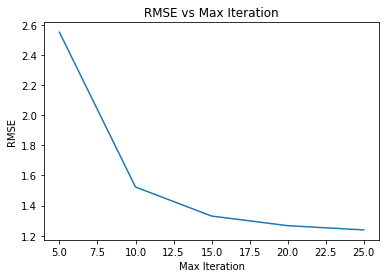

In [45]:
plt.plot(max_iter_list,rmse_iter_list)
plt.title('RMSE vs Max Iteration')
plt.xlabel('Max Iteration')
plt.ylabel('RMSE')

In [0]:
grid = {'maxIter': [25], 'rank':np.linspace(10,50,5).astype(int), 'regParam': [0.1]}

In [50]:
rank_results = hyperparameter_tuning(grid)

RMSE = 1.2759736359598604
MAE = 1.013234652918884
R-squared = -0.36705293103401915
Explained Variance = 1.0499906871826763
RMSE = 1.238508152369095
MAE = 0.9953985695147448
R-squared = -0.2879519690294159
Explained Variance = 0.9425591322578566
RMSE = 1.2257168419900661
MAE = 0.9891615326487391
R-squared = -0.2614854196254093
Explained Variance = 0.9156503683033267
RMSE = 1.2188498419628548
MAE = 0.9841657307992777
R-squared = -0.24739023185084763
Explained Variance = 0.903184919545412
RMSE = 1.2169645744548008
MAE = 0.9832248178215358
R-squared = -0.24353439093656126
Explained Variance = 0.885860700933043


Text(0, 0.5, 'RMSE')

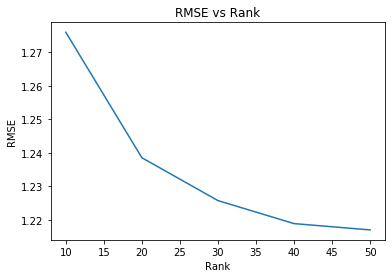

In [64]:
rank_list, rmse_rank_list = process_results(rank_results,1)
plt.plot(rank_list,rmse_rank_list)
plt.title('RMSE vs Rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')

In [0]:
# Example Run: ALS with random chosen parameters
als = ALS(maxIter=25, regParam=0.01, rank = 100, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
als_model = als.fit(train)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predicted_ratings_als = als_model.transform(val)
predicted_ratings_als = \
    predicted_ratings_als.withColumn('rating', predicted_ratings_als.prediction).drop('prediction')

In [0]:
grid = {'maxIter': [25], 'rank':[50], 'regParam':np.linspace(.1,.5,5)}

In [75]:
regularization_results = hyperparameter_tuning(grid)

RMSE = 1.2169645744548008
MAE = 0.9832248178215358
R-squared = -0.24353439093656126
Explained Variance = 0.885860700933043
RMSE = 1.1640439288424664
MAE = 0.9305057156356168
R-squared = -0.13773382073215124
Explained Variance = 0.7953085838150661
RMSE = 1.1406048570880876
MAE = 0.9070658746782891
R-squared = -0.09237653186393868
Explained Variance = 0.7549266842809625
RMSE = 1.128702033107405
MAE = 0.8947194598618473
R-squared = -0.0696964211022415
Explained Variance = 0.7267663496817095
RMSE = 1.1354100241163725
MAE = 0.9032929411767453
R-squared = -0.0824488325779884
Explained Variance = 0.7174145455959837


Text(0, 0.5, 'RMSE')

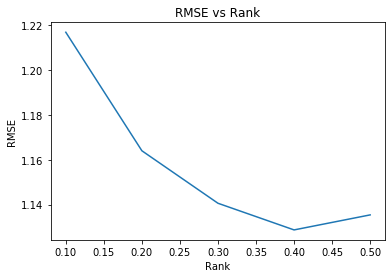

In [77]:
reg_list, rmse_reg_list = process_results(regularization_results,2)
plt.plot(reg_list,rmse_reg_list)
plt.title('RMSE vs Rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')

Peak performance after tuning, 1.1287 RMSE

In [0]:
# averageprecision_als, precision_als, ndcg_als = \
# ranking_metric(val, predicted_ratings_als)

## Performance Comparison on Test Set

In [0]:
# combine train and cv


# run three models on traincv and evaluate on test


# Create visualization of metrics change